## Lab 8: Model Building

First we will start with accuracy measures using confusion matrix

Then will be back to chapter 7 in the Steven Skiena book and the accompanying notebook that generated the figures below for choosing threshold estimators, and ROC

Then will work on cross validation examples from scikit-learn python library.

# Confusion Matrix

The following code shows a confusion matrix for a multi-class machine learning problem with ten labels, so for example an algorithms for recognizing the ten digits from handwritten characters.

In [38]:
import numpy as np
cm = np.array(
[[5825,    1,   49,   23,    7,   46,   30,   12,   21,   26],
 [   1, 6654,   48,   25,   10,   32,   19,   62,  111,   10],
 [   2,   20, 5561,   69,   13,   10,    2,   45,   18,    2],
 [   6,   26,   99, 5786,    5,  111,    1,   41,  110,   79],
 [   4,   10,   43,    6, 5533,   32,   11,   53,   34,   79],
 [   3,    1,    2,   56,    0, 4954,   23,    0,   12,    5],
 [  31,    4,   42,   22,   45,  103, 5806,    3,   34,    3],
 [   0,    4,   30,   29,    5,    6,    0, 5817,    2,   28],
 [  35,    6,   63,   58,    8,   59,   26,   13, 5394,   24],
 [  16,   16,   21,   57,  216,   68,    0,  219,  115, 5693]])

The functions 'precision' and 'recall' calculate values for a label, whereas the function 'precision_macro_average' the precision for the whole classification problem calculates.

In [39]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()
def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows
def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns
print("label precision recall")
for label in range(10):
    print(f"{label:5d} {precision(label, cm):9.3f} {recall(label, cm):6.3f}")

label precision recall
    0     0.983  0.964
    1     0.987  0.954
    2     0.933  0.968
    3     0.944  0.924
    4     0.947  0.953
    5     0.914  0.980
    6     0.981  0.953
    7     0.928  0.982
    8     0.922  0.949
    9     0.957  0.887


In [40]:
print("precision total:", precision_macro_average(cm))
print("recall total:", recall_macro_average(cm))

precision total: 0.9496885564052286
recall total: 0.9514531547877969


In [41]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 
accuracy(cm)

0.9503833333333334

# Chapter 7 Examples:

Evaluating a classifier means measuring how accurately our predicted labels match the gold standard labels in the evaluation set. For the common case of two distinct labels or classes (binary classification), we typically call the smaller and more interesting of the two classes as positive and the larger/other class as negative. In a spam classification problem, the spam would typically be positive and the ham (non-spam) would be negative. This labeling aims to ensure that identifying the positives is at least as hard as identifying the negatives, although often the test instances are selected so that the classes are of equal cardinality. There are four possible results of what the classification model could do on any given instance, which defines the confusion matrix or contingency table shown in Figure 7.3:

• True Positives (TP): Here our classifier labels a positive item as positive, resulting in a win for the classifier.
• True Negatives (TN): Here the classifier correctly determines that a mem- ber of the negative class deserves a negative label. Another win.
• False Positives (FP): The classifier mistakenly calls a negative item as a positive, resulting in a “type I” classification error.
• False Negatives (FN): The classifier mistakenly declares a positive item as negative, resulting in a “type II” classification error.


In [1]:
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve
%matplotlib inline

### Figure 7.3 and 7.6 Left
#### Data Source: https://www.statcrunch.com/app/index.php?dataid=1406047

/Users/manal/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  
/Users/manal/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  # This is added back by InteractiveShellApp.init_path()


Text(175, 0.027, 'TP')

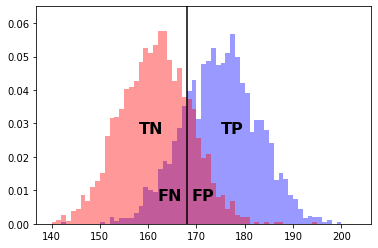

In [4]:
path = "weight.xls"
data = pd.ExcelFile(path).parse('Sheet1')
men = data[data["Gender"]==1]
women = data[data["Gender"]==0]

bsize = 75
n, bins, patches = plt.hist(men["Height"], bins=range(140,max(men["Height"]),1), normed=True, \
                            color="blue",  alpha=0.4, linewidth=0)

plt.hist(women["Height"], bins=range(140,max(men["Height"]),1), normed=True, \
         color="red", alpha=0.4, linewidth=0)

plt.ylim(0,0.065)
plt.vlines(168, 0, 0.08)

plt.text(158, 0.027, "TN", fontsize=16, fontweight="bold")
plt.text(162, 0.007, "FN", fontsize=16, fontweight="bold")
plt.text(169, 0.007, "FP", fontsize=16, fontweight="bold")
plt.text(175, 0.027, "TP", fontsize=16, fontweight="bold")

Figure 7.3 illustrates where these result classes fall in separating two distri- butions (men and women), where the decision variable is height as measured in centimeters. The classifier under evaluation labels everyone of height ≥ 168 centimeters as male. The purple regions represent the intersection of both male and female. These tails represent the incorrectly classified elements.

Accuracy, Precision, Recall, and F-Score

There are several different evaluation statistics which can be computed from the true/false positive/negative counts detailed above. The reason we need so many statistics is that we must defend our classifier against two baseline opponents, the sharp and the monkey.


### For Figure 7.6, need data that's not normalized.

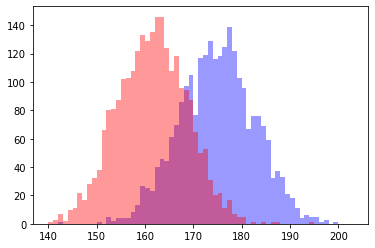

In [5]:
nM, binM, patchesM = plt.hist(men["Height"], bins=range(140,max(men["Height"]),1), \
                            color="blue",  alpha=0.4, linewidth=0)

nW, binW, patchesW = plt.hist(women["Height"], bins=range(140,max(men["Height"]),1), \
         color="red", alpha=0.4, linewidth=0)

### Figure 7.6 Right

Text(0.5, 1.0, 'ROC Curve for Gender by Height')

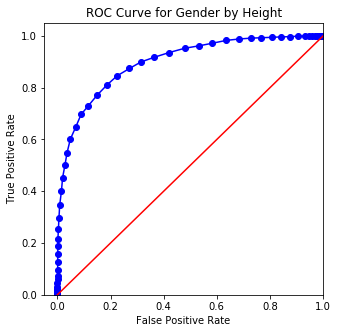

In [6]:
tpr = []
fpr = []
#total num people
totalW = len(women["Height"])
totalM = len(men["Height"])

#total num people checked.
sumW = 0
sumM = 0
total = len(data["Height"])

for i in range(len(binM)-1):
    tprate = (totalM-sumM)/float(totalM)
    fprate = (totalW-sumW)/float(totalW)
    tpr.append(tprate)
    fpr.append(fprate)
    sumM += nM[i]
    sumW += nW[i]
    
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, 'bo', fpr, tpr, 'b-')
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100), 'r-')

plt.xlim(-0.05, 1)
plt.ylim(0,1.05)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Gender by Height")

Figure 7.6: The ROC curve helps us select the best threshold to use in a classifier, by displaying the trade-off between true positives and false positive at every possible setting. The monkey ROCs the main diagonal here.

Many classifiers come with natural knobs that you can tweak to alter the trade- off between precision and recall. For example, consider systems which compute a numerical score reflecting “in classness,” perhaps by assessing how much the given test sample looks like cancer. Certain samples will score more positively than others. But where do we draw the line between positive and negative?

If our “in classness” score is accurate, then it should generally be higher for positive items than negative ones. The positive examples will define a different score distribution than the negative instances, as shown in Figure 7.6 (left). It would be great if these distributions were completely disjoint, because then there would be a score threshold t such that all instances with scores ≥ t are positive and all < t are negative. This would define a perfect classifier.

But it is more likely that the two distributions will overlap, to at least some degree, turning the problem of identifying the best threshold into a judgment call based on our relative distaste towards false positives and false negatives.

The Receiver Operating Characteristic (ROC) curve provides a visual repre- sentation of our complete space of options in putting together a classifier.

# Model selection: choosing estimators and their parameters

Every estimator exposes a score method that can judge the quality of the fit (or the prediction) on new data. Bigger is better.

Lets Try Support Vector Machines (SVM) as an efficieent Linear Classifier. More on SVM:
https://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html#support-vector-machines-svms


In [37]:
from sklearn import datasets, svm
digits = datasets.load_digits()
X_digits = digits.data
y_digits = digits.target
svc = svm.SVC(C=1, kernel='linear')
svc.fit(X_digits[:-100], y_digits[:-100]).score(X_digits[-100:], y_digits[-100:])

0.98

To get a better measure of prediction accuracy (which we can use as a proxy for goodness of fit of the model), we can successively split the data in folds that we use for training and testing:

In [11]:
import numpy as np
X_folds = np.array_split(X_digits, 3)
y_folds = np.array_split(y_digits, 3)
scores = list()
for k in range(3):
    # We use 'list' to copy, in order to 'pop' later on
    X_train = list(X_folds)
    X_test = X_train.pop(k)
    X_train = np.concatenate(X_train)
    y_train = list(y_folds)
    y_test = y_train.pop(k)
    y_train = np.concatenate(y_train)
    scores.append(svc.fit(X_train, y_train).score(X_test, y_test))
print(scores)  

[0.9348914858096828, 0.9565943238731218, 0.9398998330550918]


This is called a KFold cross-validation.

# Cross-validation generators

Scikit-learn has a collection of classes which can be used to generate lists of train/test indices for popular cross-validation strategies.
They expose a split method which accepts the input dataset to be split and yields the train/test set indices for each iteration of the chosen cross-validation strategy.
This example shows an example usage of the split method.

In [12]:
from sklearn.model_selection import KFold, cross_val_score
X = ["a", "a", "a", "b", "b", "c", "c", "c", "c", "c"]
k_fold = KFold(n_splits=5)
for train_indices, test_indices in k_fold.split(X):
    print('Train: %s | test: %s' % (train_indices, test_indices))

Train: [2 3 4 5 6 7 8 9] | test: [0 1]
Train: [0 1 4 5 6 7 8 9] | test: [2 3]
Train: [0 1 2 3 6 7 8 9] | test: [4 5]
Train: [0 1 2 3 4 5 8 9] | test: [6 7]
Train: [0 1 2 3 4 5 6 7] | test: [8 9]


The cross-validation can then be performed easily:

In [13]:
[svc.fit(X_digits[train], y_digits[train]).score(X_digits[test], y_digits[test])
    for train, test in k_fold.split(X_digits)]  

[0.9638888888888889,
 0.9222222222222223,
 0.9637883008356546,
 0.9637883008356546,
 0.9303621169916435]

The cross-validation score can be directly calculated using the cross_val_score helper. Given an estimator, the cross-validation object and the input dataset, the cross_val_score splits the data repeatedly into a training and a testing set, trains the estimator using the training set and computes the scores based on the testing set for each iteration of cross-validation.

By default the estimator’s score method is used to compute the individual scores.
Refer the metrics module to learn more on the available scoring methods:
https://scikit-learn.org/stable/modules/metrics.html#metrics


In [15]:
cross_val_score(svc, X_digits, y_digits, cv=k_fold, n_jobs=-1)

array([0.96388889, 0.92222222, 0.9637883 , 0.9637883 , 0.93036212])

n_jobs=-1 means that the computation will be dispatched on all the CPUs of the computer.
Alternatively, the scoring argument can be provided to specify an alternative scoring method.

In [16]:
cross_val_score(svc, X_digits, y_digits, cv=k_fold, scoring='precision_macro')

array([0.96578289, 0.92708922, 0.96681476, 0.96362897, 0.93192644])

# Cross-validation generators

**KFold (n_splits, shuffle, random_state):** Splits it into K folds, trains on K-1 and then tests on the left-out.

**StratifiedKFold (n_splits, shuffle, random_state):** Same as K-Fold but preserves the class distribution within each fold.

**GroupKFold (n_splits):** Ensures that the same group is not in both testing and training sets.

**ShuffleSplit (n_splits, test_size, train_size, random_state):** Generates train/test indices based on random permutation.

**StratifiedShuffleSplit:** Same as shuffle split but preserves the class distribution within each iteration.

**GroupShuffleSplit:** Ensures that the same group is not in both testing and training sets.

**LeaveOneGroupOut ():** Takes a group array to group observations.

**LeavePGroupsOut (n_groups):** Leave P groups out.

**LeaveOneOut ():** Leave one observation out.

**LeavePOut (p):** Leave P observations out.	

**PredefinedSplit:** Generates train/test indices based on predefined splits.


On the digits dataset, plot the cross-validation score of a SVC estimator with an linear kernel as a function of parameter C (use a logarithmic grid of points, from 1 to 10).

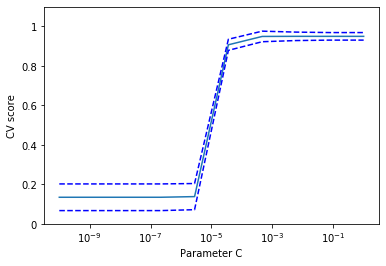

In [19]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn import datasets, svm

digits = datasets.load_digits()
X = digits.data
y = digits.target

svc = svm.SVC(kernel='linear')
C_s = np.logspace(-10, 0, 10)

scores = list()
scores_std = list()
for C in C_s:
    svc.C = C
    this_scores = cross_val_score(svc, X, y, cv=5, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

# Do the plotting
import matplotlib.pyplot as plt
plt.figure()
plt.semilogx(C_s, scores)
plt.semilogx(C_s, np.array(scores) + np.array(scores_std), 'b--')
plt.semilogx(C_s, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter C')
plt.ylim(0, 1.1)
plt.show()

# Grid-search and cross-validated estimators

scikit-learn provides an object that, given data, computes the score during the fit of an estimator on a parameter grid and chooses the parameters to maximize the cross-validation score. This object takes an estimator during the construction and exposes an estimator API:

In [25]:
from sklearn.model_selection import GridSearchCV, cross_val_score

Cs = np.logspace(-6, -1, 10)
clf = GridSearchCV(estimator=svc, param_grid=dict(C=Cs),n_jobs=-1)
clf.fit(X_digits[:1000], y_digits[:1000])        


/Users/manal/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='linear',
                           max_iter=-1, probability=False, random_state=None,
                           shrinking=True, tol=0.001, verbose=False),
             iid='warn', n_jobs=-1,
             param_grid={'C': array([1.00000000e-06, 3.59381366e-06, 1.29154967e-05, 4.64158883e-05,
       1.66810054e-04, 5.99484250e-04, 2.15443469e-03, 7.74263683e-03,
       2.78255940e-02, 1.00000000e-01])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [26]:
clf.best_score_     

0.925

In [27]:
clf.best_estimator_.C 

0.007742636826811277

In [28]:
# Prediction performance on test set is not as good as on train set
clf.score(X_digits[1000:], y_digits[1000:])      

0.9435382685069009

By default, the GridSearchCV uses a 3-fold cross-validation. However, if it detects that a classifier is passed, rather than a regressor, it uses a stratified 3-fold. The default will change to a 5-fold cross-validation in version 0.22.

# Nested cross-validation

In [29]:
cross_val_score(clf, X_digits, y_digits) 

/Users/manal/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/manal/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/manal/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/manal/miniconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warn

array([0.93853821, 0.96327212, 0.94463087])

Two cross-validation loops are performed in parallel: one by the GridSearchCV estimator to set gamma and the other one by cross_val_score to measure the prediction performance of the estimator. The resulting scores are unbiased estimates of the prediction score on new data.

Warning You cannot nest objects with parallel computing (n_jobs different than 1).



# Cross-validated estimators

Cross-validation to set a parameter can be done more efficiently on an algorithm-by-algorithm basis. This is why, for certain estimators, scikit-learn exposes Cross-validation: evaluating estimator performance estimators that set their parameter automatically by cross-validation:

https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation



In [30]:
from sklearn import linear_model, datasets
lasso = linear_model.LassoCV(cv=3)
diabetes = datasets.load_diabetes()
X_diabetes = diabetes.data
y_diabetes = diabetes.target
lasso.fit(X_diabetes, y_diabetes)  

LassoCV(alphas=None, copy_X=True, cv=3, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [31]:
# The estimator chose automatically its lambda:
lasso.alpha_ 

0.012291895087486161

These estimators are called similarly to their counterparts, with ‘CV’ appended to their name.

### Cross-validation on diabetes Dataset Exercise

On the diabetes dataset, find the optimal regularization parameter alpha.
Bonus: How much can you trust the selection of alpha?

A tutorial exercise which uses cross-validation with linear models.



Answer to the bonus question: how much can you trust the selection of alpha?

Alpha parameters maximising the generalization score on different
subsets of the data:
[fold 0] alpha: 0.05968, score: 0.54209
[fold 1] alpha: 0.04520, score: 0.15523
[fold 2] alpha: 0.07880, score: 0.45193

Answer: Not very much since we obtained different alphas for different
subsets of the data and moreover, the scores for these alphas differ
quite substantially.


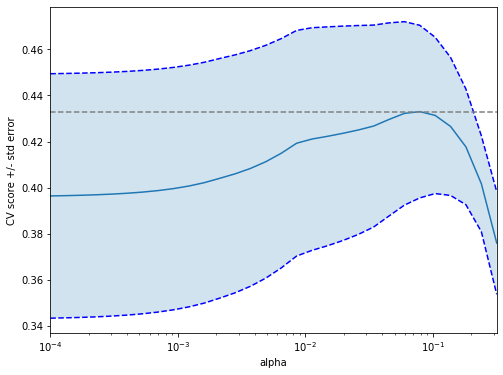

In [32]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

diabetes = datasets.load_diabetes()
X = diabetes.data[:150]
y = diabetes.target[:150]

lasso = Lasso(random_state=0, max_iter=10000)
alphas = np.logspace(-4, -0.5, 30)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

# #############################################################################
# Bonus: how much can you trust the selection of alpha?

# To answer this question we use the LassoCV object that sets its alpha
# parameter automatically from the data by internal cross-validation (i.e. it
# performs cross-validation on the training data it receives).
# We use external cross-validation to see how much the automatically obtained
# alphas differ across different cross-validation folds.
lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=0, max_iter=10000)
k_fold = KFold(3)

print("Answer to the bonus question:",
      "how much can you trust the selection of alpha?")
print()
print("Alpha parameters maximising the generalization score on different")
print("subsets of the data:")
for k, (train, test) in enumerate(k_fold.split(X, y)):
    lasso_cv.fit(X[train], y[train])
    print("[fold {0}] alpha: {1:.5f}, score: {2:.5f}".
          format(k, lasso_cv.alpha_, lasso_cv.score(X[test], y[test])))


plt.show()

Answer: Not very much since we obtained different alphas for different
subsets of the data and moreover, the scores for these alphas differ
quite substantially.

# Non Linear Model Estimation

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting. The sub-sample size is always the same as the original input sample size but the samples are drawn with replacement if bootstrap=True (default).

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

X, y = make_regression(n_features=4, n_informative=2,random_state=0, shuffle=False)
regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100)
regr.fit(X, y)  

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [34]:
print(regr.feature_importances_)
print(regr.predict([[0, 0, 0, 0]]))

[0.18146984 0.81473937 0.00145312 0.00233767]
[-8.32987858]


# Example Prediction Latency
This is an example showing the prediction latency of various scikit-learn estimators.
The goal is to measure the latency one can expect when doing predictions either in bulk or atomic (i.e. one by one) mode.
The plots represent the distribution of the prediction latency as a boxplot.


Benchmarking SGDRegressor(alpha=0.01, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.25,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='elasticnet', power_t=0.25,
             random_state=None, shuffle=True, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
Benchmarking RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)
Benchmarking SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', ke

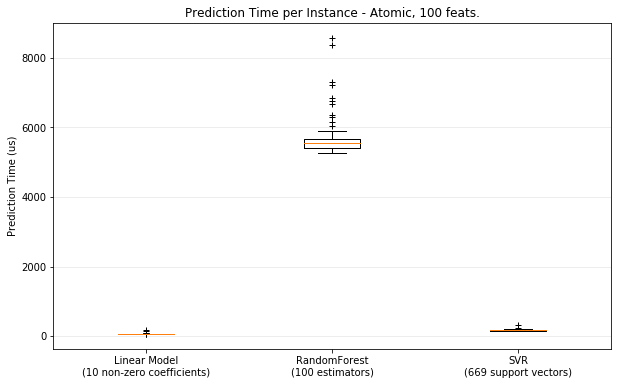

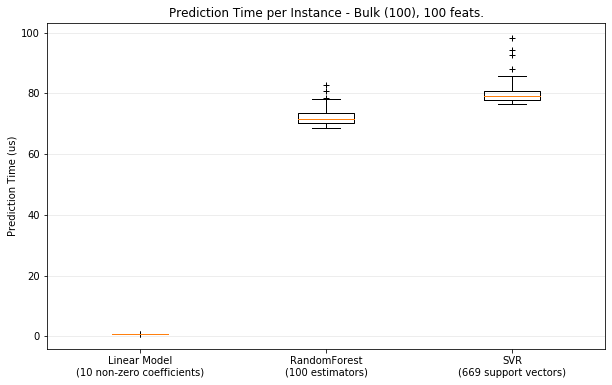

benchmarking with 100 features
benchmarking with 250 features
benchmarking with 500 features


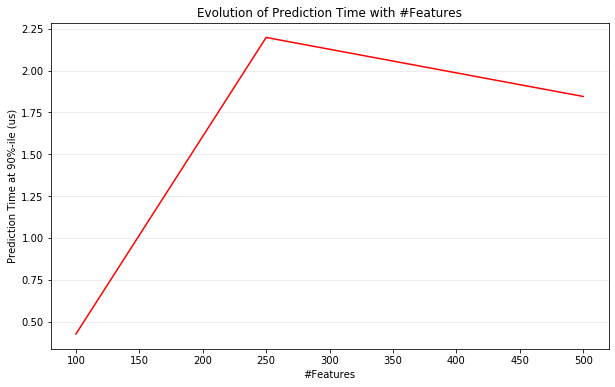

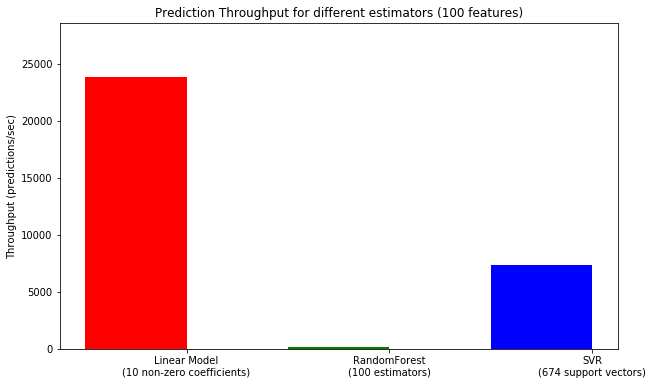

example run in 10.42s


In [36]:
# Authors: Eustache Diemert <eustache@diemert.fr>
# License: BSD 3 clause

from collections import defaultdict

import time
import gc
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets.samples_generator import make_regression
from sklearn.ensemble.forest import RandomForestRegressor
from sklearn.linear_model.ridge import Ridge
from sklearn.linear_model.stochastic_gradient import SGDRegressor
from sklearn.svm.classes import SVR
from sklearn.utils import shuffle


def _not_in_sphinx():
    # Hack to detect whether we are running by the sphinx builder
    return '__file__' in globals()


def atomic_benchmark_estimator(estimator, X_test, verbose=False):
    """Measure runtime prediction of each instance."""
    n_instances = X_test.shape[0]
    runtimes = np.zeros(n_instances, dtype=np.float)
    for i in range(n_instances):
        instance = X_test[[i], :]
        start = time.time()
        estimator.predict(instance)
        runtimes[i] = time.time() - start
    if verbose:
        print("atomic_benchmark runtimes:", min(runtimes), np.percentile(
            runtimes, 50), max(runtimes))
    return runtimes


def bulk_benchmark_estimator(estimator, X_test, n_bulk_repeats, verbose):
    """Measure runtime prediction of the whole input."""
    n_instances = X_test.shape[0]
    runtimes = np.zeros(n_bulk_repeats, dtype=np.float)
    for i in range(n_bulk_repeats):
        start = time.time()
        estimator.predict(X_test)
        runtimes[i] = time.time() - start
    runtimes = np.array(list(map(lambda x: x / float(n_instances), runtimes)))
    if verbose:
        print("bulk_benchmark runtimes:", min(runtimes), np.percentile(
            runtimes, 50), max(runtimes))
    return runtimes


def benchmark_estimator(estimator, X_test, n_bulk_repeats=30, verbose=False):
    """
    Measure runtimes of prediction in both atomic and bulk mode.

    Parameters
    ----------
    estimator : already trained estimator supporting `predict()`
    X_test : test input
    n_bulk_repeats : how many times to repeat when evaluating bulk mode

    Returns
    -------
    atomic_runtimes, bulk_runtimes : a pair of `np.array` which contain the
    runtimes in seconds.

    """
    atomic_runtimes = atomic_benchmark_estimator(estimator, X_test, verbose)
    bulk_runtimes = bulk_benchmark_estimator(estimator, X_test, n_bulk_repeats,
                                             verbose)
    return atomic_runtimes, bulk_runtimes


def generate_dataset(n_train, n_test, n_features, noise=0.1, verbose=False):
    """Generate a regression dataset with the given parameters."""
    if verbose:
        print("generating dataset...")

    X, y, coef = make_regression(n_samples=n_train + n_test,
                                 n_features=n_features, noise=noise, coef=True)

    random_seed = 13
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=n_train, test_size=n_test, random_state=random_seed)
    X_train, y_train = shuffle(X_train, y_train, random_state=random_seed)

    X_scaler = StandardScaler()
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)

    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(y_train[:, None])[:, 0]
    y_test = y_scaler.transform(y_test[:, None])[:, 0]

    gc.collect()
    if verbose:
        print("ok")
    return X_train, y_train, X_test, y_test


def boxplot_runtimes(runtimes, pred_type, configuration):
    """
    Plot a new `Figure` with boxplots of prediction runtimes.

    Parameters
    ----------
    runtimes : list of `np.array` of latencies in micro-seconds
    cls_names : list of estimator class names that generated the runtimes
    pred_type : 'bulk' or 'atomic'

    """

    fig, ax1 = plt.subplots(figsize=(10, 6))
    bp = plt.boxplot(runtimes, )

    cls_infos = ['%s\n(%d %s)' % (estimator_conf['name'],
                                  estimator_conf['complexity_computer'](
                                      estimator_conf['instance']),
                                  estimator_conf['complexity_label']) for
                 estimator_conf in configuration['estimators']]
    plt.setp(ax1, xticklabels=cls_infos)
    plt.setp(bp['boxes'], color='black')
    plt.setp(bp['whiskers'], color='black')
    plt.setp(bp['fliers'], color='red', marker='+')

    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)

    ax1.set_axisbelow(True)
    ax1.set_title('Prediction Time per Instance - %s, %d feats.' % (
        pred_type.capitalize(),
        configuration['n_features']))
    ax1.set_ylabel('Prediction Time (us)')

    plt.show()


def benchmark(configuration):
    """Run the whole benchmark."""
    X_train, y_train, X_test, y_test = generate_dataset(
        configuration['n_train'], configuration['n_test'],
        configuration['n_features'])

    stats = {}
    for estimator_conf in configuration['estimators']:
        print("Benchmarking", estimator_conf['instance'])
        estimator_conf['instance'].fit(X_train, y_train)
        gc.collect()
        a, b = benchmark_estimator(estimator_conf['instance'], X_test)
        stats[estimator_conf['name']] = {'atomic': a, 'bulk': b}

    cls_names = [estimator_conf['name'] for estimator_conf in configuration[
        'estimators']]
    runtimes = [1e6 * stats[clf_name]['atomic'] for clf_name in cls_names]
    boxplot_runtimes(runtimes, 'atomic', configuration)
    runtimes = [1e6 * stats[clf_name]['bulk'] for clf_name in cls_names]
    boxplot_runtimes(runtimes, 'bulk (%d)' % configuration['n_test'],
                     configuration)


def n_feature_influence(estimators, n_train, n_test, n_features, percentile):
    """
    Estimate influence of the number of features on prediction time.

    Parameters
    ----------

    estimators : dict of (name (str), estimator) to benchmark
    n_train : nber of training instances (int)
    n_test : nber of testing instances (int)
    n_features : list of feature-space dimensionality to test (int)
    percentile : percentile at which to measure the speed (int [0-100])

    Returns:
    --------

    percentiles : dict(estimator_name,
                       dict(n_features, percentile_perf_in_us))

    """
    percentiles = defaultdict(defaultdict)
    for n in n_features:
        print("benchmarking with %d features" % n)
        X_train, y_train, X_test, y_test = generate_dataset(n_train, n_test, n)
        for cls_name, estimator in estimators.items():
            estimator.fit(X_train, y_train)
            gc.collect()
            runtimes = bulk_benchmark_estimator(estimator, X_test, 30, False)
            percentiles[cls_name][n] = 1e6 * np.percentile(runtimes,
                                                           percentile)
    return percentiles


def plot_n_features_influence(percentiles, percentile):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    colors = ['r', 'g', 'b']
    for i, cls_name in enumerate(percentiles.keys()):
        x = np.array(sorted([n for n in percentiles[cls_name].keys()]))
        y = np.array([percentiles[cls_name][n] for n in x])
        plt.plot(x, y, color=colors[i], )
    ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                   alpha=0.5)
    ax1.set_axisbelow(True)
    ax1.set_title('Evolution of Prediction Time with #Features')
    ax1.set_xlabel('#Features')
    ax1.set_ylabel('Prediction Time at %d%%-ile (us)' % percentile)
    plt.show()


def benchmark_throughputs(configuration, duration_secs=0.1):
    """benchmark throughput for different estimators."""
    X_train, y_train, X_test, y_test = generate_dataset(
        configuration['n_train'], configuration['n_test'],
        configuration['n_features'])
    throughputs = dict()
    for estimator_config in configuration['estimators']:
        estimator_config['instance'].fit(X_train, y_train)
        start_time = time.time()
        n_predictions = 0
        while (time.time() - start_time) < duration_secs:
            estimator_config['instance'].predict(X_test[[0]])
            n_predictions += 1
        throughputs[estimator_config['name']] = n_predictions / duration_secs
    return throughputs


def plot_benchmark_throughput(throughputs, configuration):
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ['r', 'g', 'b']
    cls_infos = ['%s\n(%d %s)' % (estimator_conf['name'],
                                  estimator_conf['complexity_computer'](
                                      estimator_conf['instance']),
                                  estimator_conf['complexity_label']) for
                 estimator_conf in configuration['estimators']]
    cls_values = [throughputs[estimator_conf['name']] for estimator_conf in
                  configuration['estimators']]
    plt.bar(range(len(throughputs)), cls_values, width=0.5, color=colors)
    ax.set_xticks(np.linspace(0.25, len(throughputs) - 0.75, len(throughputs)))
    ax.set_xticklabels(cls_infos, fontsize=10)
    ymax = max(cls_values) * 1.2
    ax.set_ylim((0, ymax))
    ax.set_ylabel('Throughput (predictions/sec)')
    ax.set_title('Prediction Throughput for different estimators (%d '
                 'features)' % configuration['n_features'])
    plt.show()


# #############################################################################
# Main code

start_time = time.time()

# #############################################################################
# Benchmark bulk/atomic prediction speed for various regressors
configuration = {
    'n_train': int(1e3),
    'n_test': int(1e2),
    'n_features': int(1e2),
    'estimators': [
        {'name': 'Linear Model',
         'instance': SGDRegressor(penalty='elasticnet', alpha=0.01,
                                  l1_ratio=0.25, fit_intercept=True,
                                  tol=1e-4),
         'complexity_label': 'non-zero coefficients',
         'complexity_computer': lambda clf: np.count_nonzero(clf.coef_)},
        {'name': 'RandomForest',
         'instance': RandomForestRegressor(n_estimators=100),
         'complexity_label': 'estimators',
         'complexity_computer': lambda clf: clf.n_estimators},
        {'name': 'SVR',
         'instance': SVR(kernel='rbf'),
         'complexity_label': 'support vectors',
         'complexity_computer': lambda clf: len(clf.support_vectors_)},
    ]
}
benchmark(configuration)

# benchmark n_features influence on prediction speed
percentile = 90
percentiles = n_feature_influence({'ridge': Ridge()},
                                  configuration['n_train'],
                                  configuration['n_test'],
                                  [100, 250, 500], percentile)
plot_n_features_influence(percentiles, percentile)

# benchmark throughput
throughputs = benchmark_throughputs(configuration)
plot_benchmark_throughput(throughputs, configuration)

stop_time = time.time()
print("example run in %.2fs" % (stop_time - start_time))

More Examples in:
    
    https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html#sphx-glr-auto-examples-ensemble-plot-voting-regressor-py
    
    https://scikit-learn.org/stable/auto_examples/ensemble/plot_random_forest_regression_multioutput.html#sphx-glr-auto-examples-ensemble-plot-random-forest-regression-multioutput-py